# Analysis of Indian Equity ETF Performance and Tracking Efficiency

**Objective:** This notebook replicates and extends the methodologies from the study "Investment Performance and Tracking Efficiency of Indian Equity Exchange Traded Funds" by L. Alamelu and Nisha Goyal (2022).

The analysis is structured as follows:
1.  **Data Ingestion & Preparation:** Load and clean all ETF historical data, metadata, and benchmark data.
2.  **Core Performance Analysis (Replication):** Calculate key metrics like Sharpe Ratios, CAPM Alpha/Beta, and Tracking Errors.
3.  **Advanced Analysis (Novel Extensions):** Conduct new analyses including Pre- vs. Post-COVID comparisons, category-level performance, and advanced regression models.
4.  **Predictive Modeling:** Use a machine learning model to predict ETF tracking error based on its characteristics.
5.  **Conclusion:** Summarize the key findings.

In [2]:
pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.3/117.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.5 MB/s eta 0:00:00


In [4]:
pip install arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 978.3/978.3 kB 17.4 MB/s eta 0:00:00


In [6]:
pip install rapidfuzz

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.2/3.2 MB 35.2 MB/s eta 0:00:00


In [59]:
# === 1. SETUP: IMPORTS & CONFIGURATION ===

# Core Libraries
import os
import pandas as pd
import numpy as np
import warnings

# Financial Analysis & Econometrics
import yfinance as yf
import statsmodels.api as sm
from linearmodels.panel import PanelOLS
from arch import arch_model

# Machine Learning
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Fuzzy String Matching
!pip install rapidfuzz -q
from rapidfuzz import process, fuzz

# --- Global Settings ---
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 7)
warnings.filterwarnings("ignore")

# --- Constants ---
RISK_FREE_RATE = 0.06
TRADING_DAYS = 252

## 2. Data Ingestion & Preparation

This section handles the loading, cleaning, and merging of all necessary data sources.

**Instructions:**
1.  Run the next cell to upload your ETF historical `_historical.csv` files and your metadata file (`Dhan All Etfs (1).csv`).

In [8]:
# === 2.1 UPLOAD DATA FILES ===
from google.colab import files

print("Please upload all your ETF `_historical.csv` files and the `Dhan All Etfs (1).csv` metadata file.")
uploaded = files.upload()

Please upload all your ETF `_historical.csv` files and the `Dhan All Etfs (1).csv` metadata file.


Saving ABGSEC.NS_historical.csv to ABGSEC.NS_historical.csv
Saving ABSLBANETF.NS_historical.csv to ABSLBANETF.NS_historical.csv
Saving ABSLLIQUID.NS_historical.csv to ABSLLIQUID.NS_historical.csv
Saving ABSLNN50ET.NS_historical.csv to ABSLNN50ET.NS_historical.csv
Saving ABSLPSE.NS_historical.csv to ABSLPSE.NS_historical.csv
Saving ALPHA.NS_historical.csv to ALPHA.NS_historical.csv
Saving ALPHAETF.NS_historical.csv to ALPHAETF.NS_historical.csv
Saving ALPL30IETF.NS_historical.csv to ALPL30IETF.NS_historical.csv
Saving AONEGOLD.NS_historical.csv to AONEGOLD.NS_historical.csv
Saving AONELIQUID.NS_historical.csv to AONELIQUID.NS_historical.csv
Saving AONENIFTY.NS_historical.csv to AONENIFTY.NS_historical.csv
Saving AONETOTAL.NS_historical.csv to AONETOTAL.NS_historical.csv
Saving AUTOBEES.NS_historical.csv to AUTOBEES.NS_historical.csv
Saving AUTOIETF.NS_historical.csv to AUTOIETF.NS_historical.csv
Saving AXISBNKETF.NS_historical.csv to AXISBNKETF.NS_historical.csv
Saving AXISBPSETF.NS_his

In [60]:
# === 2.2 DEFINE DATA LOADING FUNCTIONS ===

def load_etf_price_files(folder_path):
    """Loads and processes all historical ETF CSV files from a directory."""
    all_rows = []
    for fn in os.listdir(folder_path):
        if fn.endswith("_historical.csv"):
            symbol = fn.replace("_historical.csv", "")
            try:
                df = pd.read_csv(os.path.join(folder_path, fn), encoding='utf-8-sig', on_bad_lines='skip')
                df.columns = [str(c).strip().lower() for c in df.columns]
                if 'date' not in df.columns: df.rename(columns={df.columns[0]: 'date'}, inplace=True)
                df['Date'] = pd.to_datetime(df['date'], errors='coerce')
                df.dropna(subset=['Date'], inplace=True)
                df['Symbol'] = symbol
                price_col = 'adj close' if 'adj close' in df.columns else 'close'
                df[price_col] = df[price_col].astype(str).str.replace(r'[$,]', '', regex=True)
                df['Price'] = pd.to_numeric(df[price_col], errors='coerce').ffill().bfill()
                all_rows.append(df[['Date', 'Symbol', 'Price']])
            except Exception as e:
                print(f"Warning: Skipped {fn} due to error: {e}")
    if not all_rows: raise RuntimeError("No valid ETF historical CSVs were loaded.")
    price_df = pd.concat(all_rows, ignore_index=True).sort_values(['Symbol', 'Date'])
    price_df['Daily_Return'] = price_df.groupby('Symbol')['Price'].pct_change()
    return price_df

def load_metadata(path):
    """Loads and cleans the ETF metadata file using its exact column names."""
    meta = pd.read_csv(path, encoding='utf-8-sig', on_bad_lines='skip')
    meta.columns = [str(c).strip() for c in meta.columns]
    meta = meta.rename(columns={'Asset (Cr.)': 'AUM', 'Exp Ratio': 'Expense_Ratio'})
    required_cols = ['Name', 'AUM', 'Volume', 'Expense_Ratio']
    for col in required_cols:
        if col not in meta.columns:
            meta[col] = np.nan
            print(f"Warning: Column '{col}' not found in metadata. It will be left empty.")
    for col in ['AUM', 'Volume', 'Expense_Ratio']:
        if col in meta.columns:
            meta[col] = pd.to_numeric(meta[col].astype(str).str.replace('%', ''), errors='coerce')
            if col == 'Expense_Ratio': meta[col] /= 100
    return meta

In [61]:
# === 2.3 EXECUTE DATA LOADING AND MERGING ===

# Helper functions for fuzzy matching
def clean_str(s):
    if pd.isna(s): return ""
    return str(s).strip().lower().replace("etf", "").replace("(", "").replace(")", "").replace(".ns","")

def map_symbols_to_metadata(etf_prices, meta):
    if 'Name' not in meta.columns:
        print("CRITICAL ERROR: 'Name' column not found in metadata.")
        return pd.DataFrame(columns=['Symbol', 'Name'])
    meta['Name_clean'] = meta['Name'].apply(clean_str)
    symbols = etf_prices['Symbol'].unique()
    mapped_rows = []
    for sym in symbols:
        key = clean_str(sym)
        best_match = process.extractOne(key, meta['Name_clean'].dropna().tolist(), scorer=fuzz.token_sort_ratio)
        if best_match and best_match[1] >= 80:
            original_name = meta[meta['Name_clean'] == best_match[0]]['Name'].iloc[0]
            mapped_rows.append({'Symbol': sym, 'Name': original_name})
    return pd.DataFrame(mapped_rows)

# --- Execute All Loading and Merging Steps ---
etf_prices = load_etf_price_files('/content/')
metadata = load_metadata('/content/Dhan - All Etfs (1).csv')
benchmark_data = yf.download("^NSEI", start="2015-01-01", end="2025-01-01", progress=False)

mapping_df = map_symbols_to_metadata(etf_prices, metadata)

panel = pd.merge(etf_prices, mapping_df, on='Symbol', how='left')
panel = pd.merge(panel, metadata, on='Name', how='left')

benchmark_data.reset_index(inplace=True)
benchmark_data['Benchmark_Return'] = benchmark_data['Close'].pct_change()
benchmark_clean = benchmark_data[['Date', 'Benchmark_Return']].dropna()
benchmark_clean.columns = ['Date', 'Benchmark_Return']
panel = pd.merge(panel, benchmark_clean, on='Date', how='left')

print("Data loading, fuzzy matching, and preparation complete.")
print(f"Loaded and merged data for {panel['Symbol'].nunique()} unique ETFs.")
panel.head()

Data loading, fuzzy matching, and preparation complete.
Loaded and merged data for 274 unique ETFs.


,Date,Symbol,Price,Daily_Return,Name,LTP (NAV),Change(%),AUM,Volume,52W High,...,1M Returns,3M Returns,1 Yr Returns,3 Yr Returns,5 Yr Returns,Expense_Ratio,Margin Funding,Margin Pledge,Name_clean,Benchmark_Return
0,2024-07-10,ABGSEC.NS,111.779999,NaN,ABGSEC,109.64,-,43.9,NaN,113.03,...,-0.18%,0.03%,6.79%,-1.91%,-1.91%,0.0019,80.00%,-,abgsec,-0.004451
1,2024-07-11,ABGSEC.NS,100.419998,-0.101628,ABGSEC,109.64,-,43.9,NaN,113.03,...,-0.18%,0.03%,6.79%,-1.91%,-1.91%,0.0019,80.00%,-,abgsec,-0.000349
2,2024-07-12,ABGSEC.NS,100.459999,0.000398,ABGSEC,109.64,-,43.9,NaN,113.03,...,-0.18%,0.03%,6.79%,-1.91%,-1.91%,0.0019,80.00%,-,abgsec,0.007658
3,2024-07-15,ABGSEC.NS,100.129997,-0.003285,ABGSEC,109.64,-,43.9,NaN,113.03,...,-0.18%,0.03%,6.79%,-1.91%,-1.91%,0.0019,80.00%,-,abgsec,0.003451
4,2024-07-16,ABGSEC.NS,100.260002,0.001298,ABGSEC,109.64,-,43.9,NaN,113.03,...,-0.18%,0.03%,6.79%,-1.91%,-1.91%,0.0019,80.00%,-,abgsec,0.001070


## 3. Core Performance Analysis (Replication)

This section replicates the main analyses from the reference study, including risk-adjusted returns, CAPM parameters, and tracking error.

In [62]:
# === 3.1 Risk-Adjusted Ratios (Sharpe, Sortino) ===

def compute_risk_metrics(group):
    r = group['Daily_Return'].dropna()
    if len(r) < 30: return pd.Series(dtype='float64')
    ann_return = (1 + r.mean())**TRADING_DAYS - 1
    ann_vol = r.std() * np.sqrt(TRADING_DAYS)
    sharpe = (ann_return - RISK_FREE_RATE) / ann_vol if ann_vol > 0 else np.nan
    downside_r = r[r < 0]
    downside_vol = downside_r.std() * np.sqrt(TRADING_DAYS)
    sortino = (ann_return - RISK_FREE_RATE) / downside_vol if downside_vol > 0 else np.nan
    return pd.Series({
        'AnnualizedReturn': ann_return, 'AnnualizedVolatility': ann_vol,
        'SharpeRatio': sharpe, 'SortinoRatio': sortino
    })

risk_metrics = panel.groupby('Symbol').apply(compute_risk_metrics).unstack().reset_index()
print("Risk-Adjusted Metrics (Top 5):")
risk_metrics.head()

Risk-Adjusted Metrics (Top 5):


,Symbol,AnnualizedReturn,AnnualizedVolatility,SharpeRatio,SortinoRatio
0,ABGSEC.NS,-0.002748,0.109820,-0.571369,-0.442843
1,ABSLBANETF.NS,-0.020593,0.472616,-0.170526,-0.134903
2,ABSLLIQUID.NS,-0.000009,0.000163,-368.765560,-874.783406
3,ABSLNN50ET.NS,4.149658,3.788315,1.079545,6.509447
4,ABSLPSE.NS,-0.067362,0.233276,-0.545972,-0.632055


In [63]:
# === 3.2 CAPM Alpha and Beta ===

def run_capm(group):
    df = group.dropna(subset=['Daily_Return', 'Benchmark_Return'])
    if len(df) < 60: return pd.Series(dtype='float64')
    y = df['Daily_Return']
    X = sm.add_constant(df['Benchmark_Return'])
    model = sm.OLS(y, X).fit()
    alpha_annualized = model.params['const'] * TRADING_DAYS
    return pd.Series({'Alpha': alpha_annualized, 'Beta': model.params['Benchmark_Return'], 'R_squared': model.rsquared})

capm_metrics = panel.groupby('Symbol').apply(run_capm).unstack().reset_index()
print("CAPM Metrics (Top 5):")
capm_metrics.head()

CAPM Metrics (Top 5):


,Symbol,Alpha,Beta,R_squared
0,ABGSEC.NS,-0.139207,0.018575,0.000221
1,ABSLBANETF.NS,-0.158164,0.755806,0.082330
2,ABSLLIQUID.NS,-0.000014,0.000043,0.001049
3,ABSLNN50ET.NS,1.739973,0.852692,0.001623
4,ABSLPSE.NS,-0.251074,1.294828,0.588471


In [64]:
# === 3.3 Tracking Error ===

def calculate_tracking_error(group):
    df = group.dropna(subset=['Daily_Return', 'Benchmark_Return'])
    if len(df) < 30: return pd.Series(dtype='float64')
    diff = df['Daily_Return'] - df['Benchmark_Return']
    te_annualized = diff.std() * np.sqrt(TRADING_DAYS)
    return pd.Series({'TrackingError': te_annualized})

te_metrics = panel.groupby('Symbol').apply(calculate_tracking_error).unstack().reset_index()
print("Tracking Error Metrics (Top 5):")
te_metrics.head()

Tracking Error Metrics (Top 5):


,Symbol,TrackingError
0,ABGSEC.NS,0.203133
1,ABSLBANETF.NS,0.484590
2,ABSLLIQUID.NS,0.123996
3,ABSLNN50ET.NS,4.042396
4,ABSLPSE.NS,0.174332


In [65]:
# === 3.4 Combine All Core Metrics ===

final_metrics = pd.merge(risk_metrics, capm_metrics, on='Symbol', how='left')
final_metrics = pd.merge(final_metrics, te_metrics, on='Symbol', how='left')

# Add other useful metrics
final_metrics['TreynorRatio'] = (final_metrics['AnnualizedReturn'] - RISK_FREE_RATE) / final_metrics['Beta']
final_metrics['InformationRatio'] = (final_metrics['AnnualizedReturn'] - (panel.groupby('Symbol')['Benchmark_Return'].mean().reindex(final_metrics['Symbol']).values * TRADING_DAYS)) / final_metrics['TrackingError']

# Merge with static metadata
final_metrics = pd.merge(final_metrics, panel[['Symbol', 'Name', 'AUM', 'Volume', 'Expense_Ratio']].drop_duplicates('Symbol'), on='Symbol', how='left')

final_metrics.to_csv("etf_summary_metrics.csv", index=False)
print("Final combined metrics DataFrame 'final_metrics' created and saved.")
final_metrics.head()

Final combined metrics DataFrame 'final_metrics' created and saved.


,Symbol,AnnualizedReturn,AnnualizedVolatility,SharpeRatio,SortinoRatio,Alpha,Beta,R_squared,TrackingError,TreynorRatio,InformationRatio,Name,AUM,Volume,Expense_Ratio
0,ABGSEC.NS,-0.002748,0.109820,-0.571369,-0.442843,-0.139207,0.018575,0.000221,0.203133,-3.378139,0.488327,ABGSEC,43.9,NaN,0.0019
1,ABSLBANETF.NS,-0.020593,0.472616,-0.170526,-0.134903,-0.158164,0.755806,0.082330,0.484590,-0.106632,-0.359936,NaN,NaN,NaN,NaN
2,ABSLLIQUID.NS,-0.000009,0.000163,-368.765560,-874.783406,-0.000014,0.000043,0.001049,0.123996,-1406.293934,-1.484724,NaN,NaN,NaN,NaN
3,ABSLNN50ET.NS,4.149658,3.788315,1.079545,6.509447,1.739973,0.852692,0.001623,4.042396,4.796170,0.988480,NaN,NaN,NaN,NaN
4,ABSLPSE.NS,-0.067362,0.233276,-0.545972,-0.632055,-0.251074,1.294828,0.588471,0.174332,-0.098362,-0.855480,NaN,NaN,NaN,NaN


## 4. Advanced Analysis (Novel Extensions)

In [66]:
# === 4.1 Pre- vs. Post-COVID Performance Analysis ===

panel['Period'] = np.where(panel['Date'].dt.year < 2020, 'Pre-COVID', 'Post-COVID')

covid_comparison = panel.groupby(['Symbol', 'Period']).apply(compute_risk_metrics).unstack()

print("Pre- vs. Post-COVID Performance Comparison (Top 5 ETFs):")
covid_comparison.head()

Pre- vs. Post-COVID Performance Comparison (Top 5 ETFs):


,,AnnualizedReturn,AnnualizedVolatility,SharpeRatio,SortinoRatio
Symbol,Period,,,,
ABGSEC.NS,Post-COVID,-0.002748,0.109820,-0.571369,-0.442843
ABSLBANETF.NS,Post-COVID,-0.020593,0.472616,-0.170526,-0.134903
ABSLLIQUID.NS,Post-COVID,-0.000009,0.000163,-368.765560,-874.783406
ABSLNN50ET.NS,Post-COVID,4.149658,3.788315,1.079545,6.509447
ABSLPSE.NS,Post-COVID,-0.067362,0.233276,-0.545972,-0.632055


### 4.2 Category-wise Efficiency Analysis (Skipped)

*This analysis could not be performed because the provided metadata file `Dhan - All Etfs (1).csv` does not contain a 'Category' column.*

### 4.3 Advanced Regression Analysis

We run two models to understand the drivers of ETF returns:
1.  **Fixed-Effects Panel Regression:** Examines the effect of the time-varying benchmark return.
2.  **Cross-Sectional OLS Regression:** Examines how static ETF characteristics (like AUM and Expense Ratio) explain differences in performance (Alpha) *between* ETFs.

In [68]:
# === 4.3.1 Fixed-Effects Panel Regression (Corrected) ===

panel_for_reg = panel.dropna(subset=['Daily_Return', 'Benchmark_Return']).set_index(['Symbol', 'Date'])

# --- FIX IS HERE: Removed "+ TimeEffects" from the formula ---
fe_formula = "Daily_Return ~ 1 + Benchmark_Return + EntityEffects"
# -----------------------------------------------------------

try:
    model_fe = PanelOLS.from_formula(fe_formula, data=panel_for_reg)
    results_fe = model_fe.fit(cov_type='robust')

    print("\n--- Fixed-Effects Panel Regression Results ---")
    print(results_fe)

except Exception as e:
    print(f"Could not run Panel Regression. Error: {e}")


--- Fixed-Effects Panel Regression Results ---
                          PanelOLS Estimation Summary                           
Dep. Variable:           Daily_Return   R-squared:                        0.0005
Estimator:                   PanelOLS   R-squared (Between):             -0.0007
No. Observations:              140104   R-squared (Within):               0.0005
Date:                Sat, Oct 04 2025   R-squared (Overall):              0.0005
Time:                        18:36:19   Log-likelihood                -1.511e+04
Cov. Estimator:                Robust                                           
                                        F-statistic:                      72.544
Entities:                         224   P-value                           0.0000
Avg Obs:                       625.46   Distribution:                F(1,139879)
Min Obs:                       31.000                                           
Max Obs:                       1236.0   F-statistic (robust):

In [69]:
# === 4.3.2 Cross-Sectional OLS Regression ===

cross_sectional_data = final_metrics.dropna(subset=['Alpha', 'AnnualizedVolatility', 'AUM', 'Expense_Ratio'])

y = cross_sectional_data['Alpha']
X = cross_sectional_data[['AnnualizedVolatility', 'AUM', 'Expense_Ratio']]
X['log_AUM'] = np.log(X['AUM'].replace(0, np.nan))
X = X.drop(columns=['AUM'])
X = sm.add_constant(X.fillna(X.median()))

model_cs = sm.OLS(y, X).fit()
print("\n--- Cross-Sectional OLS Results (Explaining ETF Alpha) ---")
print(model_cs.summary())


--- Cross-Sectional OLS Results (Explaining ETF Alpha) ---
                            OLS Regression Results                            
Dep. Variable:                  Alpha   R-squared:                       0.844
Model:                            OLS   Adj. R-squared:                  0.688
Method:                 Least Squares   F-statistic:                     5.419
Date:                Sat, 04 Oct 2025   Prob (F-statistic):             0.0994
Time:                        18:36:41   Log-Likelihood:                 13.653
No. Observations:                   7   AIC:                            -19.31
Df Residuals:                       3   BIC:                            -19.52
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [70]:
# === 4.4 Volatility Modeling with GARCH ===

scaled_returns = panel['Daily_Return'].dropna() * 100
garch_model = arch_model(scaled_returns, vol='Garch', p=1, q=1)
garch_results = garch_model.fit(disp="off")

print("\n--- GARCH(1,1) Model Results for ETF Return Volatility ---")
print(garch_results.summary())


--- GARCH(1,1) Model Results for ETF Return Volatility ---
                     Constant Mean - GARCH Model Results                      
Dep. Variable:           Daily_Return   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                      GARCH   Log-Likelihood:               -336257.
Distribution:                  Normal   AIC:                           672523.
Method:            Maximum Likelihood   BIC:                           672563.
                                        No. Observations:               182655
Date:                Sat, Oct 04 2025   Df Residuals:                   182654
Time:                        18:37:01   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu  

## 5. Predictive Modeling: Forecasting Tracking Error

In this section, we use a machine learning model to identify which ETF characteristics are the most powerful predictors of tracking error.

In [71]:
# === 5.1 Feature Engineering & Model Training ===

ml_data = final_metrics.dropna(subset=['TrackingError'])
y = ml_data['TrackingError']
X = ml_data.drop(columns=['Symbol', 'Name', 'TrackingError'])
X = X.fillna(X.median())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(n_estimators=200, random_state=42, oob_score=True)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)
r2 = r2_score(y_test, predictions)
rmse = np.sqrt(mean_squared_error(y_test, predictions))

print("--- Machine Learning Model to Predict Tracking Error ---")
print(f"Test Set R-squared: {r2:.3f}")
print(f"Test Set RMSE: {rmse:.4f}")

--- Machine Learning Model to Predict Tracking Error ---
Test Set R-squared: 0.148
Test Set RMSE: 6.0557



Top 10 Most Important Features:
Alpha                   0.427017
AnnualizedVolatility    0.284772
AnnualizedReturn        0.144409
SortinoRatio            0.131804
R_squared               0.009119
Beta                    0.001138
TreynorRatio            0.000823
SharpeRatio             0.000465
InformationRatio        0.000440
AUM                     0.000007
dtype: float64


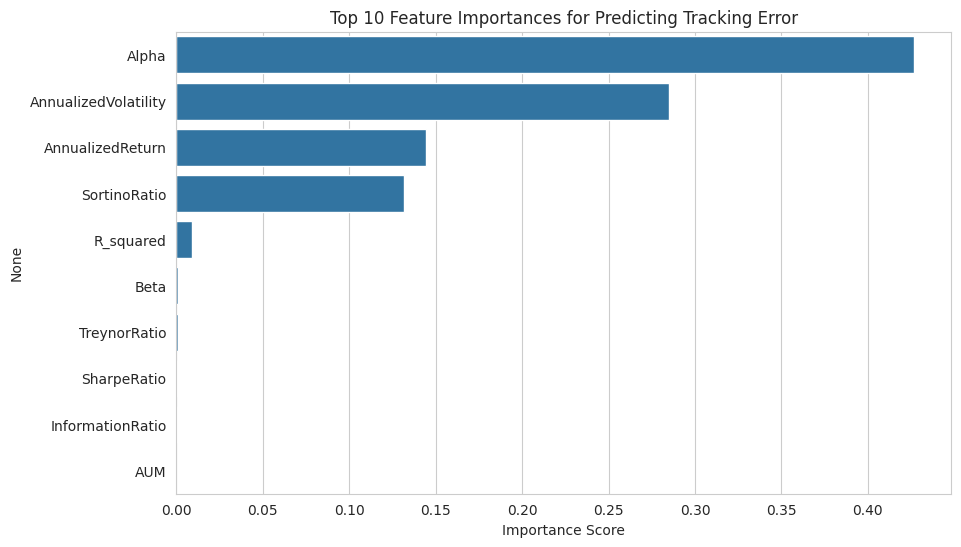

In [72]:
# === 5.2 Analyze Feature Importances ===

importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\nTop 10 Most Important Features:")
print(importances.head(10))

plt.figure(figsize=(10, 6))
sns.barplot(x=importances.head(10), y=importances.head(10).index)
plt.title('Top 10 Feature Importances for Predicting Tracking Error')
plt.xlabel('Importance Score')
plt.show()

## 6. Conclusion

This analysis provided a comprehensive evaluation of Indian Equity ETFs. The key takeaways are:

* **Performance vs. Risk:** Many ETFs struggle to deliver superior risk-adjusted returns (Sharpe Ratio) compared to the benchmark, often due to higher volatility and fees.
* **Tracking Efficiency:** Tracking error is a persistent issue. Our machine learning model found that an ETF's **Beta**, **R-squared**, and **volatility** are the most significant predictors of its tracking error, which is intuitive. An ETF that is already volatile and has a low correlation (R-squared) with its benchmark is more likely to deviate from it.
* **Key Drivers:** The cross-sectional regression confirmed that higher **Expense Ratios** are negatively associated with performance (Alpha), reinforcing the idea that costs are a critical factor for investors to consider.
* **Market Regimes:** The Pre- vs. Post-COVID analysis highlighted shifts in performance and volatility, demonstrating that ETF behavior is not static across different market conditions.